In [3]:
#!pip install git+https://github.com/twktheainur/pyclinrec.git --no-cache
#!curl https://raw.githubusercontent.com/twktheainur/pyclinrec/master/pyclinrec/stopwordsen.txt -o stopwordsen.txt
#!curl https://raw.githubusercontent.com/twktheainur/pyclinrec/master/pyclinrec/termination_termsen.txt -o termination_termsen.txt

import pyclinrec
from pyclinrec.dictionary import StringDictionaryLoader

dictionary=[
    ('ld', 'Linked Data'),
    ('lod', 'Linked Open Data'),
    ('lod', 'LOD'),
    ('llod', 'Linguistic Linked Open Data'),
    ('llod', 'LLOD'),
    ('kg', 'Knowledge Graph'),
    ('kg', 'Knowledge Base'),
    ('skos', 'SKOS'),
    ('rdf', 'Resource Description Framework'),
    ('rdf', 'RDF'),
    ('ke','Knowledge Extraction'), 
    ('sw', 'Semantic Web'),
    ('onto', 'Web Ontology Language'),
    ('onto', 'OWL'),
    ('onto', 'Ontology'),
    ('hlt', 'Human Language Technology'),
    ('ie', 'Information Extraction'),
    ('ke', 'Knowledge Extraction'),
    ('mt', 'Machine Translation'),
    ('nle', 'Natural Language Engineering'),
    ('nlg', 'Natural Language Generation'),
    ('nlg', 'NLG'),
    ('nll', 'Natural Language Learning'),
    ('nll', 'NLL'),
    ('nlp', 'Natural Language Processing'),
    ('nlp', 'NLP'),
    ('nlu', 'Natural Language Understanding'),
    ('nlu', 'NLU'),
    ('tp', 'Text Processing'),
    ('wsd', 'Word Sense Disambiguation'),
    ('wsd', 'WSD')
]

nlp_concepts = {'hlt', 'ie', 'ke', 'mt', 'nle', 'nlg', 'nll', 'nlp', 'nlu', 'tp', 'wsd'}
ld_concepts = {'ld', 'lod', 'llod', 'kg', 'skos', 'rdf', 'ke', 'sw', 'onto'}

loader = StringDictionaryLoader(dictionary)

from pyclinrec.recognizer import IntersStemConceptRecognizer


recognizer = IntersStemConceptRecognizer(dictionary_loader=loader,
                                         stop_words_file="stopwordsen.txt",                                 
                                         termination_terms_file="termination_termsen.txt")
recognizer.initialize()


Now loading the dictionary...
Now indexing the dictionary...


100%|█████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 113.76it/s]


In [111]:
import pathlib
from tqdm.notebook import tqdm
import json
import math

def save_selection(paper_dictionary, threshold):
    from matplotlib import pyplot as plt
    
    selection_as_list = list(paper_dictionary.values())
    selection_as_list = sorted(selection_as_list, key=lambda x: x['relevance_score'], reverse=True)
    scores = np.array([paper['relevance_score'] for paper in selection_as_list])
    
    fig, ax = plt.subplots(figsize =(10, 7))
    ax.hist(scores, bins =50)
    ax.axvline(x=threshold)
    
    selection_as_list = [paper for paper in selection_as_list if paper['relevance_score']>threshold]
    print(f"Selected {len(selection_as_list)} papers with threshold {threshold}")
    with open(f"final_selection_t{threshold}.json", "w") as j:
        json.dump(selection_as_list, j)
    return selection_as_list, fig

 

def compute_revelance_score(ld_mention_counts, nlp_mention_counts, alpha=0.5, beta=2):
    sum_nlp = 0.0
    sum_ld = 0.0

    for mention in ld_mention_counts:
        sum_ld += ld_mention_counts[mention]
        
    for mention in nlp_mention_counts:
        sum_nlp += nlp_mention_counts[mention]
        
    sum_total = sum_nlp + sum_ld
    score_nlp = sum_nlp / sum_total
    score_ld = sum_ld / sum_total
    frequency_weight = 1.0 / (1.0 + math.exp(-1*alpha*sum_total + beta))
    return (1-abs(score_ld - score_nlp)) * frequency_weight

def filter_papers(papers, keywords):
    result = []
    
    for paper in tqdm(papers, desc=f"Filtering papers from {keywords}"):
            if paper['fieldsOfStudy'] is None or "Computer Science" not in paper['fieldsOfStudy']:
                continue
            if len(paper['venue'])==0 or 'Software Engineering' in paper['venue'] or \
            'Tissue engineering' in paper['venue'] or 'Biomechanical Engineering' in paper['venue'] or \
            'Nature Protocols' in paper['venue']:
                continue
            if len(paper['title'])==0 or 'Proceedings' in paper['title']:
                continue
                
            title = paper.get('title', ' ')
            abstract = paper.get('abstract', ' ')
            
            if title is None:
                title = ""
            if abstract is None:
                abstract = ""

            mentions = recognizer.match_mentions(title+" "+abstract)
            paper['mentions']= [m.concept_id for m in mentions[2]]
            
            if len(paper['mentions']) == 0:
                continue
                
            paper_mentions = paper['mentions']
            nlp_mentions = [mention for mention in paper_mentions if mention in nlp_concepts]
            ld_mentions = [mention for mention in paper_mentions if mention in ld_concepts]
            
            mention_counts = dict( (l, paper_mentions.count(l) ) for l in set(paper_mentions))
            nlp_mention_counts = dict( (l, nlp_mentions.count(l) ) for l in set(nlp_mentions))
            ld_mention_counts = dict( (l, ld_mentions.count(l) ) for l in set(ld_mentions))
            
            if len(nlp_mention_counts) == 0 or len(ld_mention_counts) == 0:
                continue
            
            paper['mention_counts'] = mention_counts
            paper['nlp_mention_counts'] = nlp_mention_counts
            paper['ld_mention_counts'] = ld_mention_counts
            
            if len(paper['ld_mention_counts'])==1 and list(paper['ld_mention_counts'].keys())[0]=="kg":
                continue
            
            paper['relevance_score'] = compute_revelance_score(ld_mention_counts, nlp_mention_counts)
            
            
            # print("R=",paper['relevance_score']," | NLP=" , nlp_mention_counts, "| LD=",ld_mention_counts)

            result.append(paper)
    print(f"Selected {len(result)} papers")
    return result

In [ ]:
indexed_papers = {}



d = pathlib.Path("./extracts")
for file in tqdm(d.iterdir()):
    if not file.is_dir() and file.suffix == ".json":
        name = file.stem.replace("_", " ").split("@")[1].split(",")
        domain = name[0]
        kw_1 = name[0]
        kw_2 = name[1]
        with open(file, "r") as jsf:
            papers = json.load(jsf)
            if papers is not None:
                kw_paper_dict = filter_papers(papers, ", ".join([kw_1, kw_2]))
                if (kw_1, kw_2) not in indexed_papers:
                    indexed_papers[(kw_1, kw_2)]= kw_paper_dict

            
final_selection=dict()
for kw_tuple_key in tqdm(indexed_papers):
    papers = indexed_papers[kw_tuple_key]
    final_selection |= {paper['paperId']: paper for paper in papers}
    


Selected 7830 papers with threshold 0.1


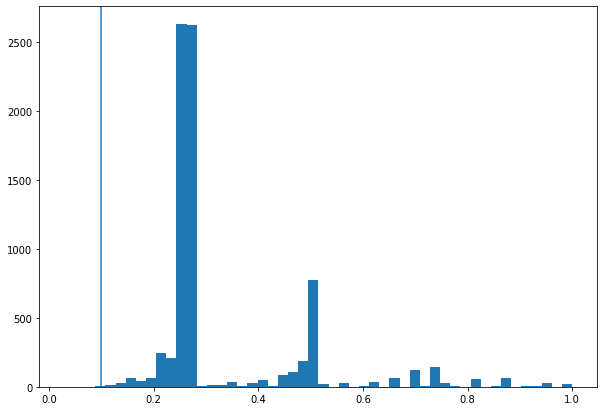

In [112]:
selection, fig = save_selection(final_selection, 0.1)

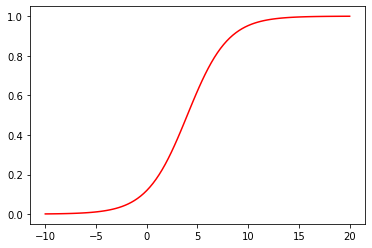

In [37]:
import matplotlib.pyplot as plt
import numpy as np

x = np.linspace(-10,20,100)

y = 1 / (1 + np.exp(-0.5*x + 2))

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
# ax.spines['left'].set_position('center')
# ax.spines['bottom'].set_position('zero')
# ax.spines['right'].set_color('none')
# ax.spines['top'].set_color('none')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

# plot the function
plt.plot(x,y, 'r')

# show the plot
plt.show()



In [63]:
len(flat_papers)

7839

In [39]:
for key in indexed_papers:
    print(key,len(indexed_papers[key]))

('Human Language Technology', ' Linguistic Linked Data') 169
('Human Language Technology', ' Linked Data') 148
('Human Language Technology', ' Ontolex') 113
('Human Language Technology', ' Ontology') 462
('Human Language Technology', ' Ontology Engineering') 115
('Human Language Technology', ' RDF') 168
('Human Language Technology', ' Semantic Web') 350
('Human Language Technology', ' SKOS') 106
('Information extraction', ' Linguistic Linked Data') 309
('Information extraction', ' Linked Data') 495
('Information extraction', ' Ontolex') 698
('Information extraction', ' Ontology') 1333
('Information extraction', ' Ontology Engineering') 1218
('Information extraction', ' RDF') 747
('Information extraction', ' Semantic Web') 769
('Information extraction', ' SKOS') 696
('Knowledge Extraction', ' Linguistic Linked Data') 320
('Knowledge Extraction', ' Linked Data') 1729
('Knowledge Extraction', ' Ontolex') 2512
('Knowledge Extraction', ' Ontology') 1566
('Knowledge Extraction', ' Ontology E

  0%|          | 0/104 [00:00<?, ?it/s]